# Producing images for `README.rst`

**Scott Prahl**

**Nov 2025**

This noteboook produces the readme images.  

Some cells will not run in jupyterlite because downloading urls is not allowed.

In [1]:
%config InlineBackend.figure_format = 'retina'

import sys
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as iio

if sys.platform == "emscripten":
    import piplite

    await piplite.install("laserbeamsize")

import laserbeamsize as lbs

In [2]:
pixel_size_µm = 3.75  # microns
pixel_size_mm = pixel_size_µm / 1000  # mm

if sys.platform == "emscripten":
    repo = ""
else:
    repo = "https://github.com/scottprahl/laserbeamsize/raw/main/docs/images/"

### Simple analysis of local image

In [3]:
image_name = repo + "t-hene.pgm"
beam = iio.imread(image_name)
x, y, d_major, d_minor, phi = lbs.beam_size(beam)

print("The center of the beam ellipse is at (%.0f, %.0f)" % (x, y))
print("The ellipse diameter (closest to horizontal) is %.0f pixels" % d_major)
print("The ellipse diameter (closest to   vertical) is %.0f pixels" % d_minor)
print("The ellipse is rotated %.0f° CCW from the horizontal" % (phi * 180 / 3.1416))

The center of the beam ellipse is at (651, 492)
The ellipse diameter (closest to horizontal) is 369 pixels
The ellipse diameter (closest to   vertical) is 347 pixels
The ellipse is rotated -12° CCW from the horizontal


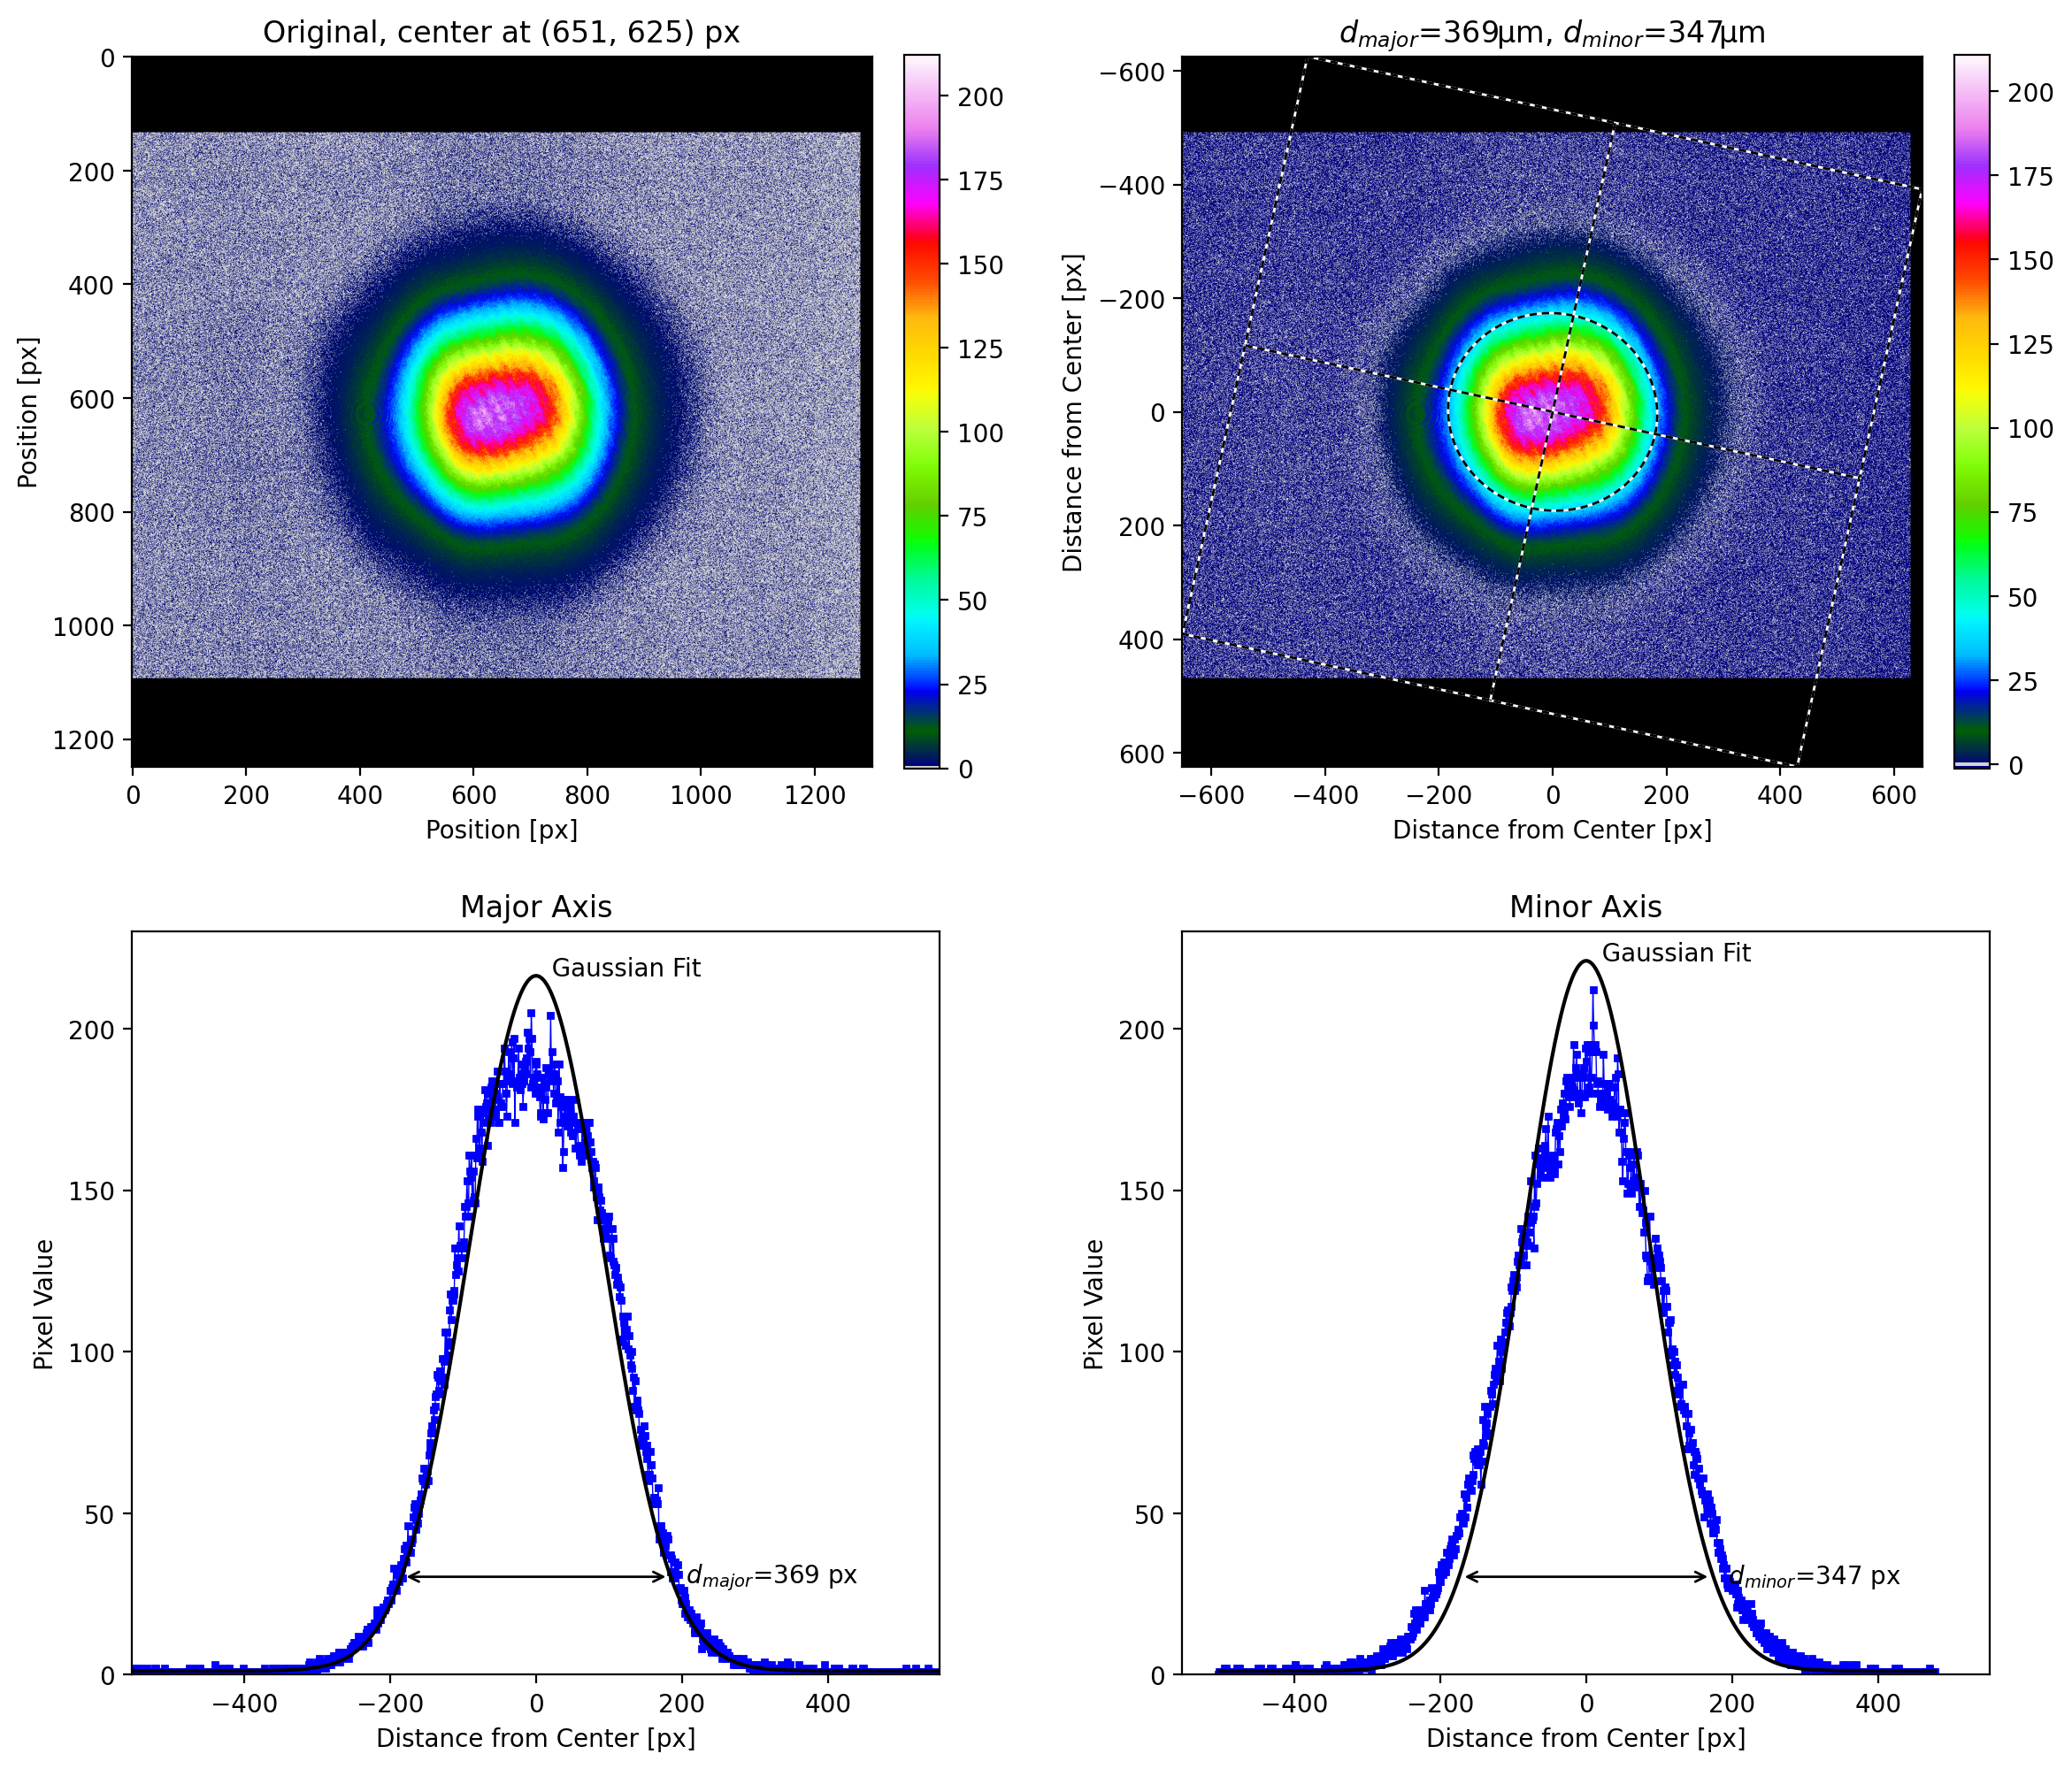

In [4]:
lbs.plot_image_analysis(beam, crop=True)
plt.savefig("hene-report.png", bbox_inches="tight")
plt.show()

### Analysis of color image

Just grab a color wikipedia image and slice.

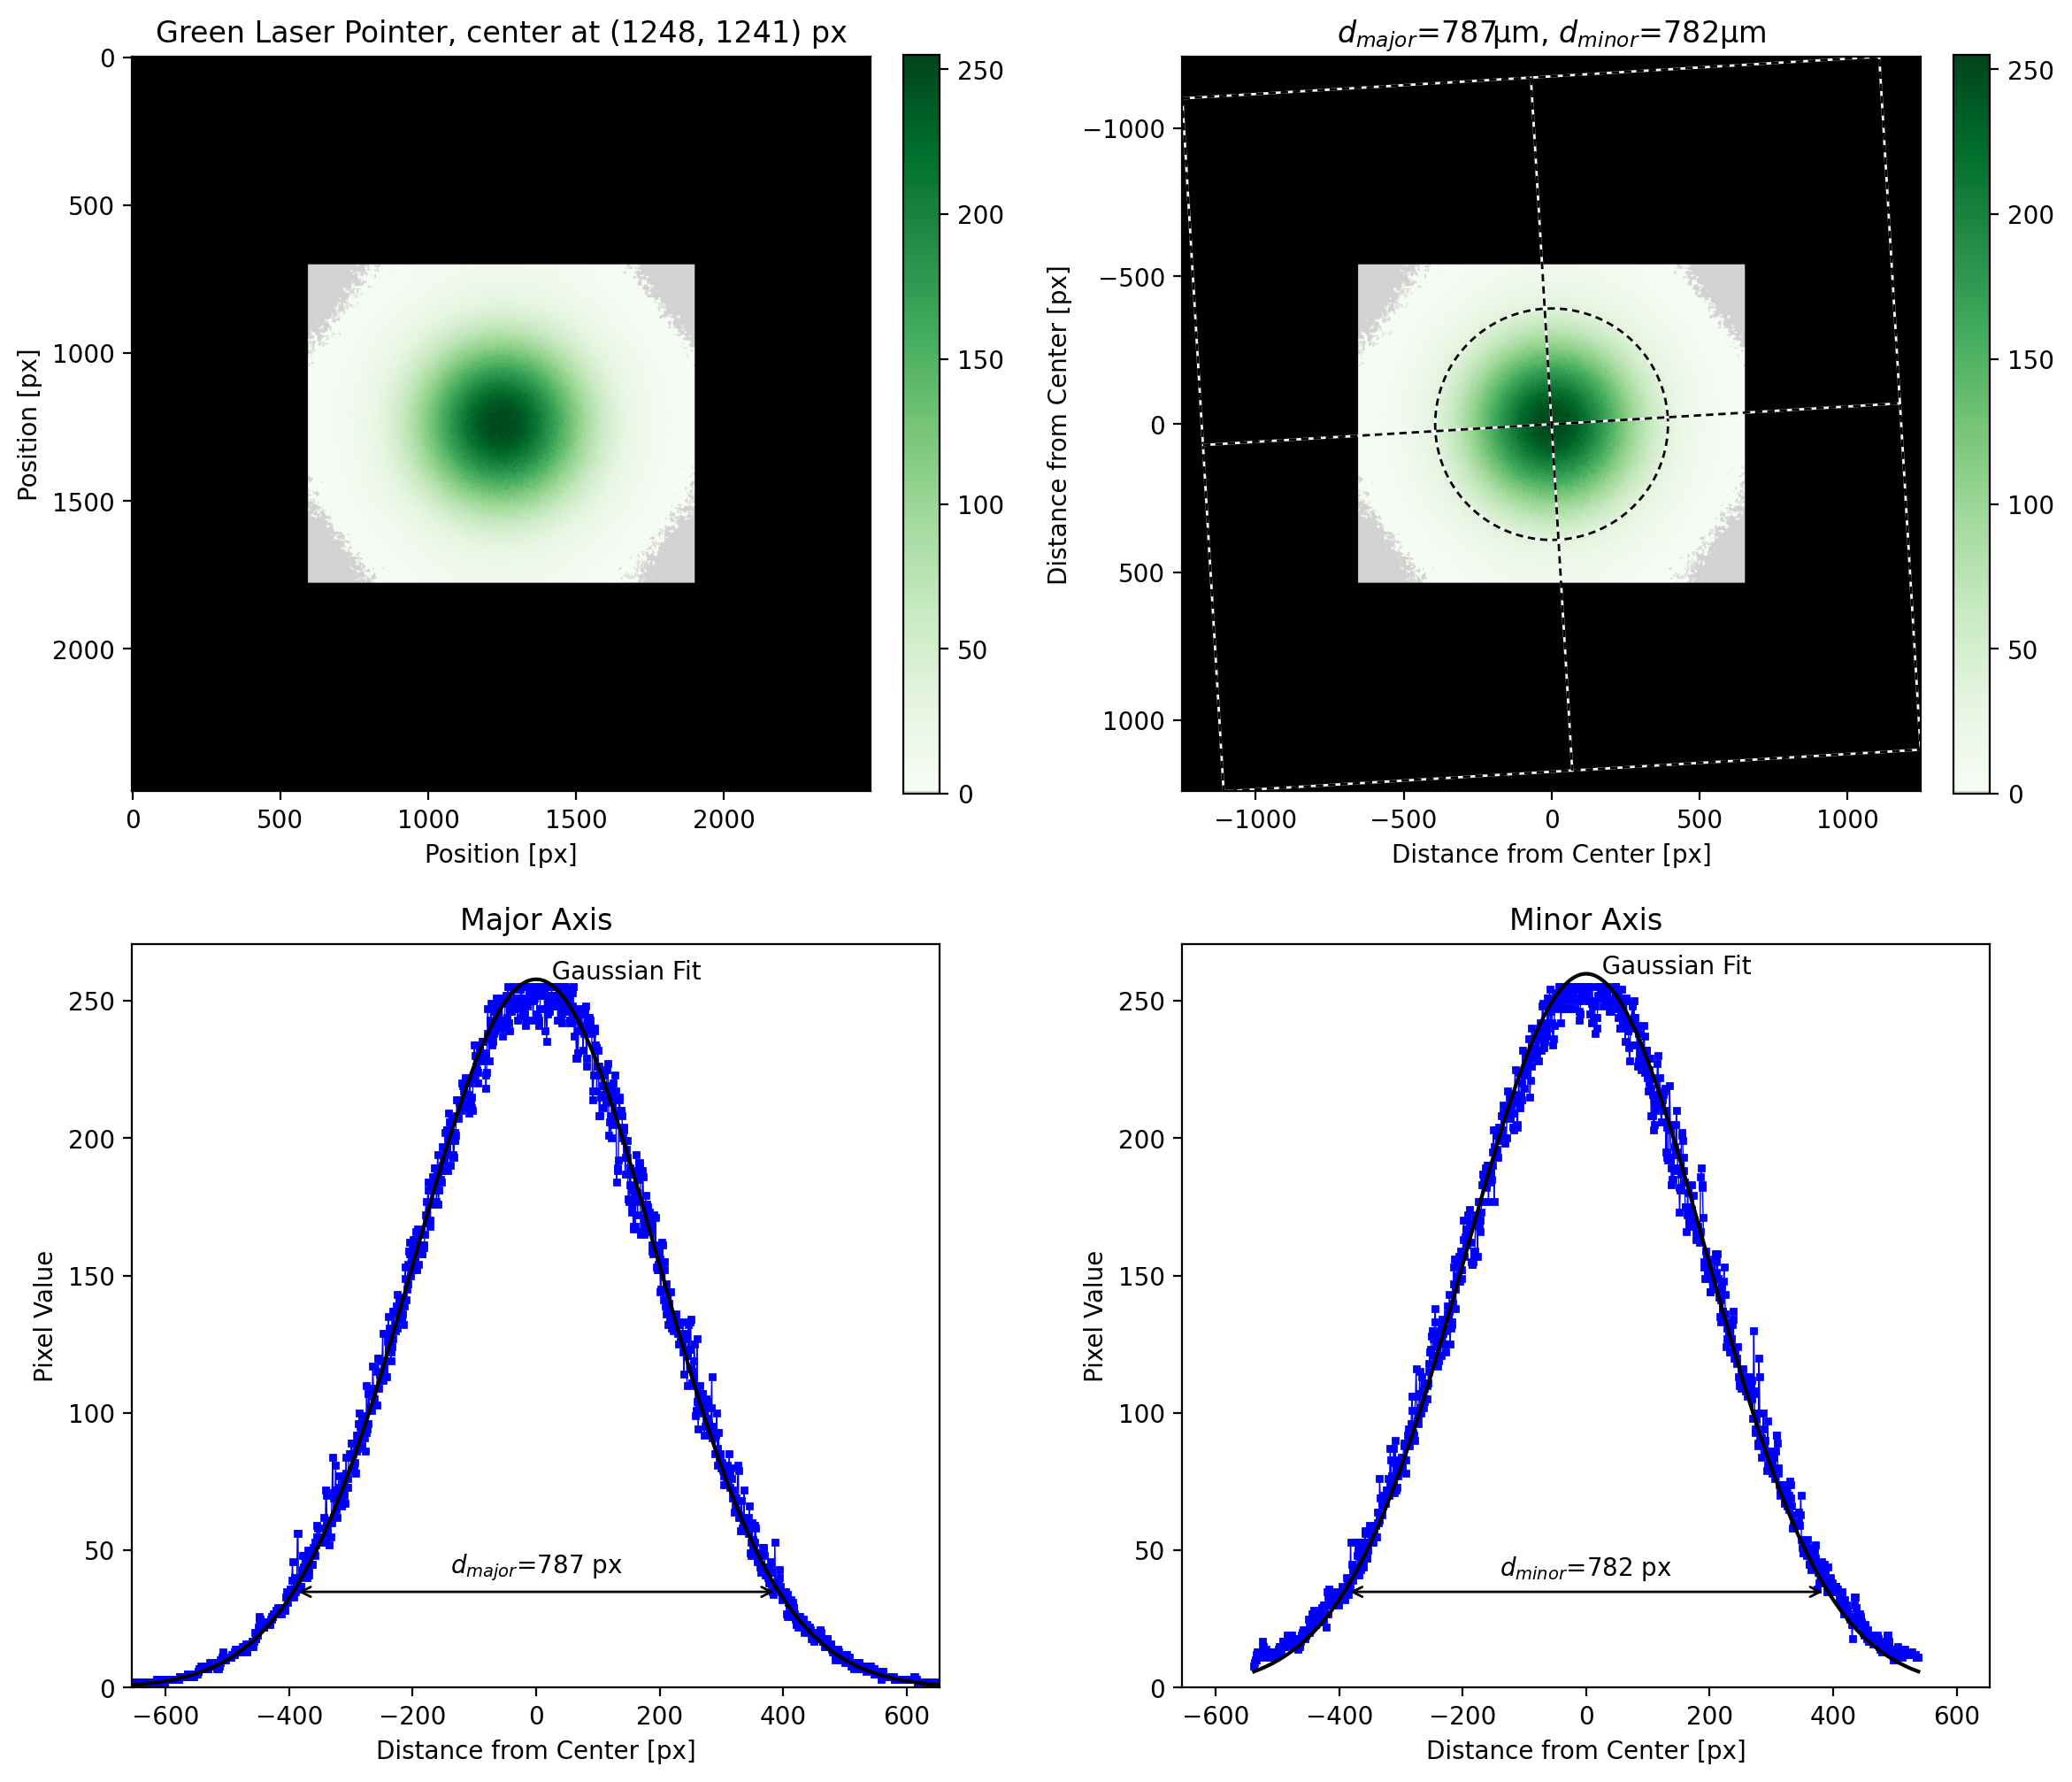

In [5]:
url = "https://upload.wikimedia.org/wikipedia/commons/7/74/Green_laser_pointer_TEM00_profile.JPG"
r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"}, timeout=15)
r.raise_for_status()

beam = iio.imread(io.BytesIO(r.content), extension=".jpg")
green_channel = beam[:, :, 1]
lbs.plot_image_analysis(green_channel, "Green Laser Pointer", cmap="Greens", crop=True)

### Nice asymmetric image 

This image uncovered a bug with semi-major and semi-minor axis identification.

The image was contributed by Werefkin

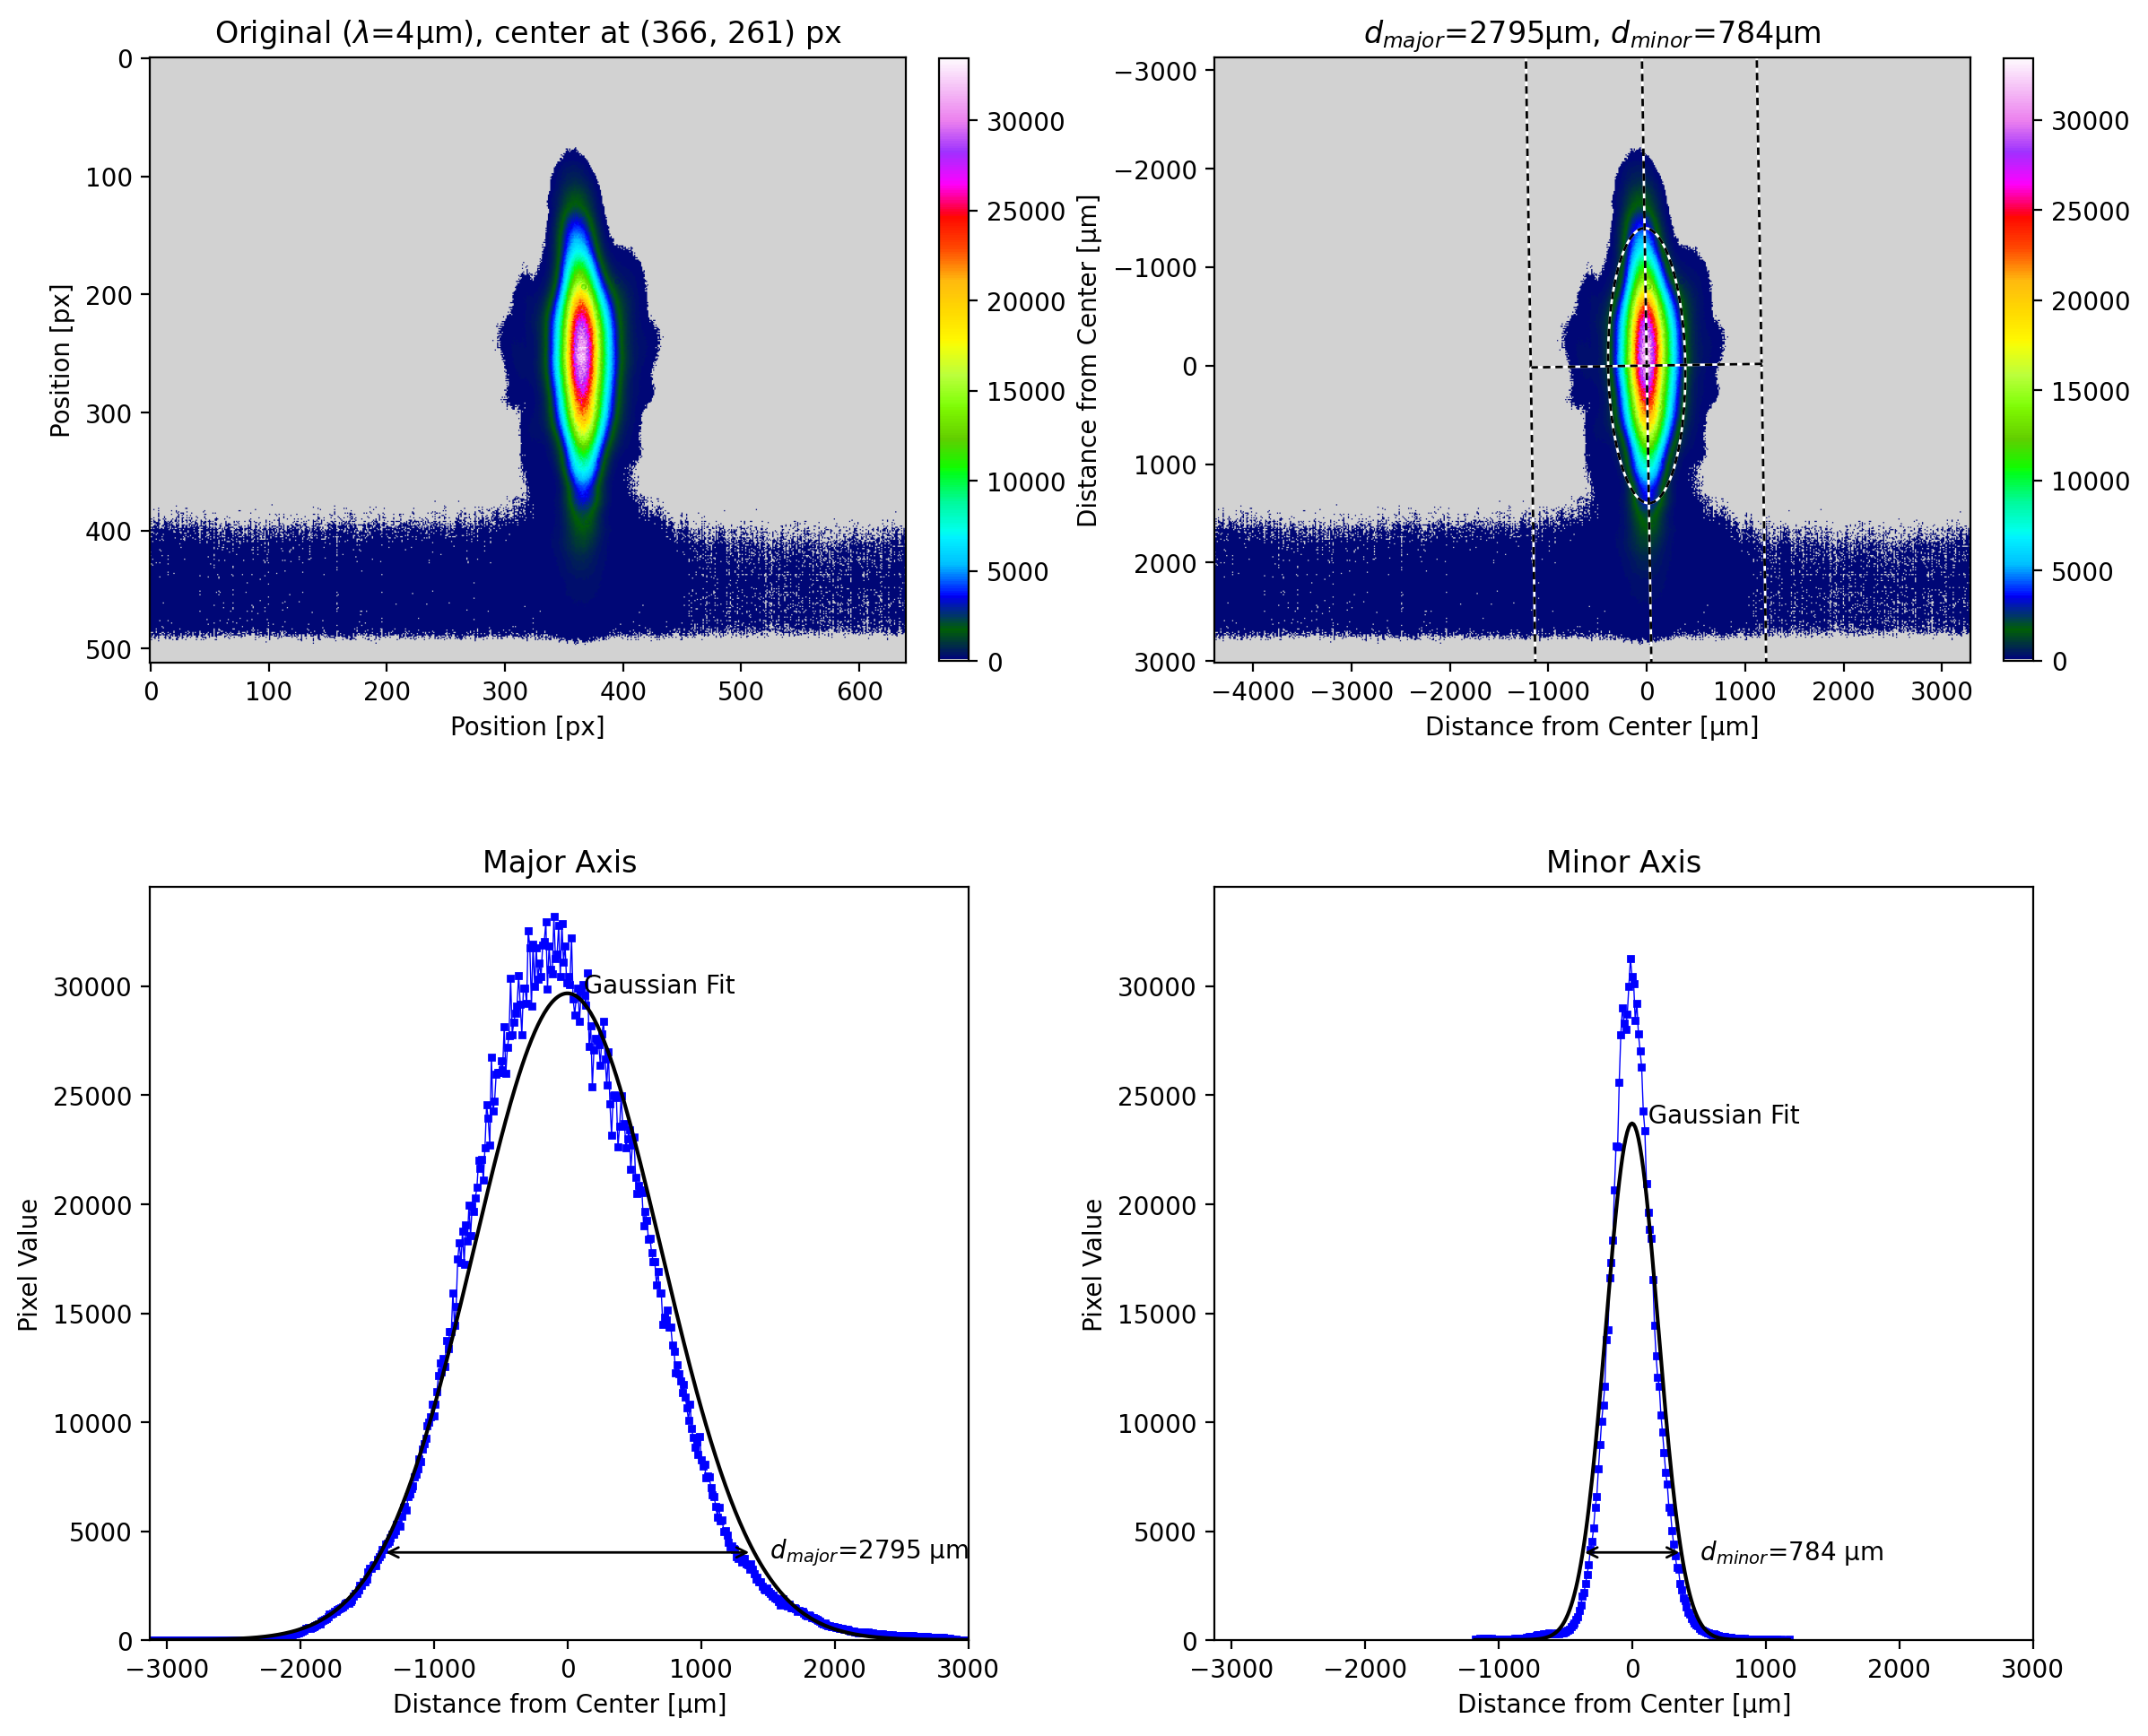

In [6]:
# Created using an f=750 mm spherical mirror for focusing under 45 degrees incidence
# The pixel size is 12 µm, wavelength is 4 µm (actually it is a polychromatic beam)

# have to use io.BytesIO so np.load() can work with URL
image_name = repo + "astigmatic_beam_profile.npy"
response = requests.get(image_name)
response.raise_for_status()
beam = np.load(io.BytesIO(response.content))  # Works!

# if image is local, then the above is not necessary
# beam = np.load("astigmatic_beam_profile.npy")

lbs.plot_image_analysis(beam, r"Original ($\lambda$=4µm)", pixel_size=12, units="µm")
plt.savefig("astigmatic-report.png", bbox_inches="tight")
plt.show()

### 12 bit image stored as 16 bit values

The 12-bit pixel image stored as high-order bits in 16-bit values

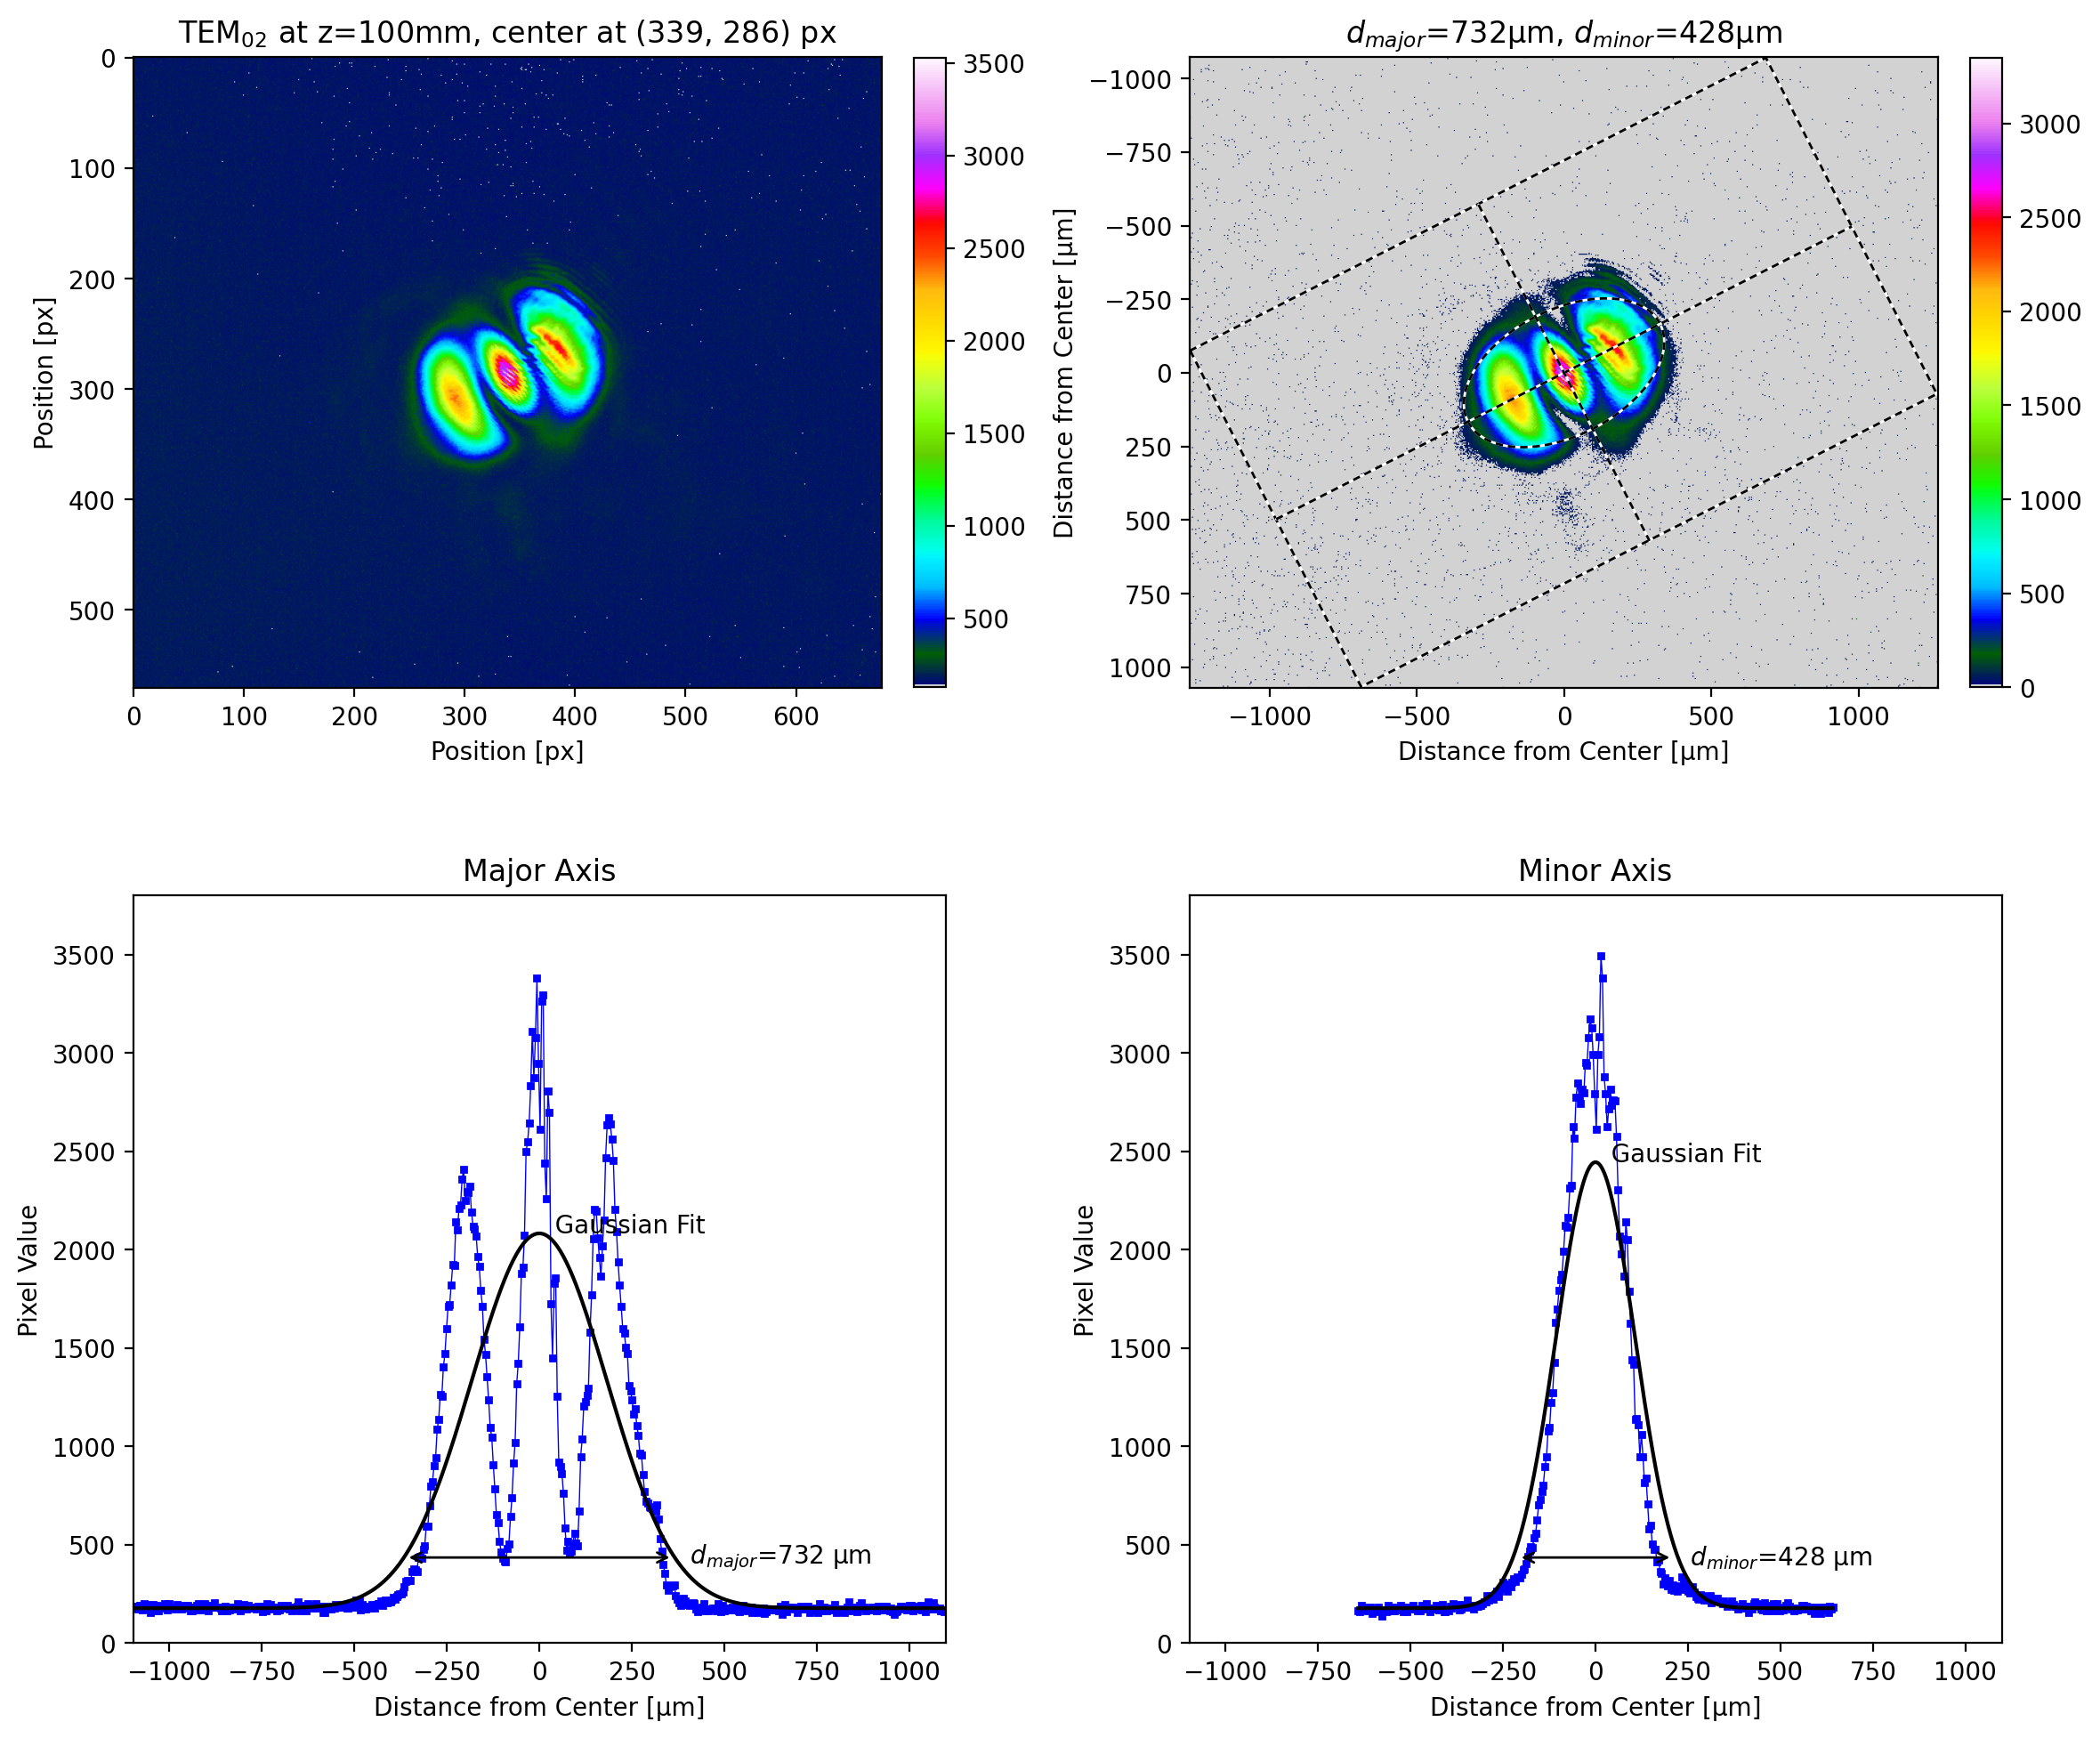

In [7]:
image_name = repo + "TEM02_100mm.pgm"

tem02 = iio.imread(image_name) >> 4
lbs.plot_image_analysis(tem02, title=r"TEM$_{02}$ at z=100mm", pixel_size=3.75, iso_noise=False, crop=True)
plt.savefig("tem02.png", bbox_inches="tight")
plt.show()

### M² analysis

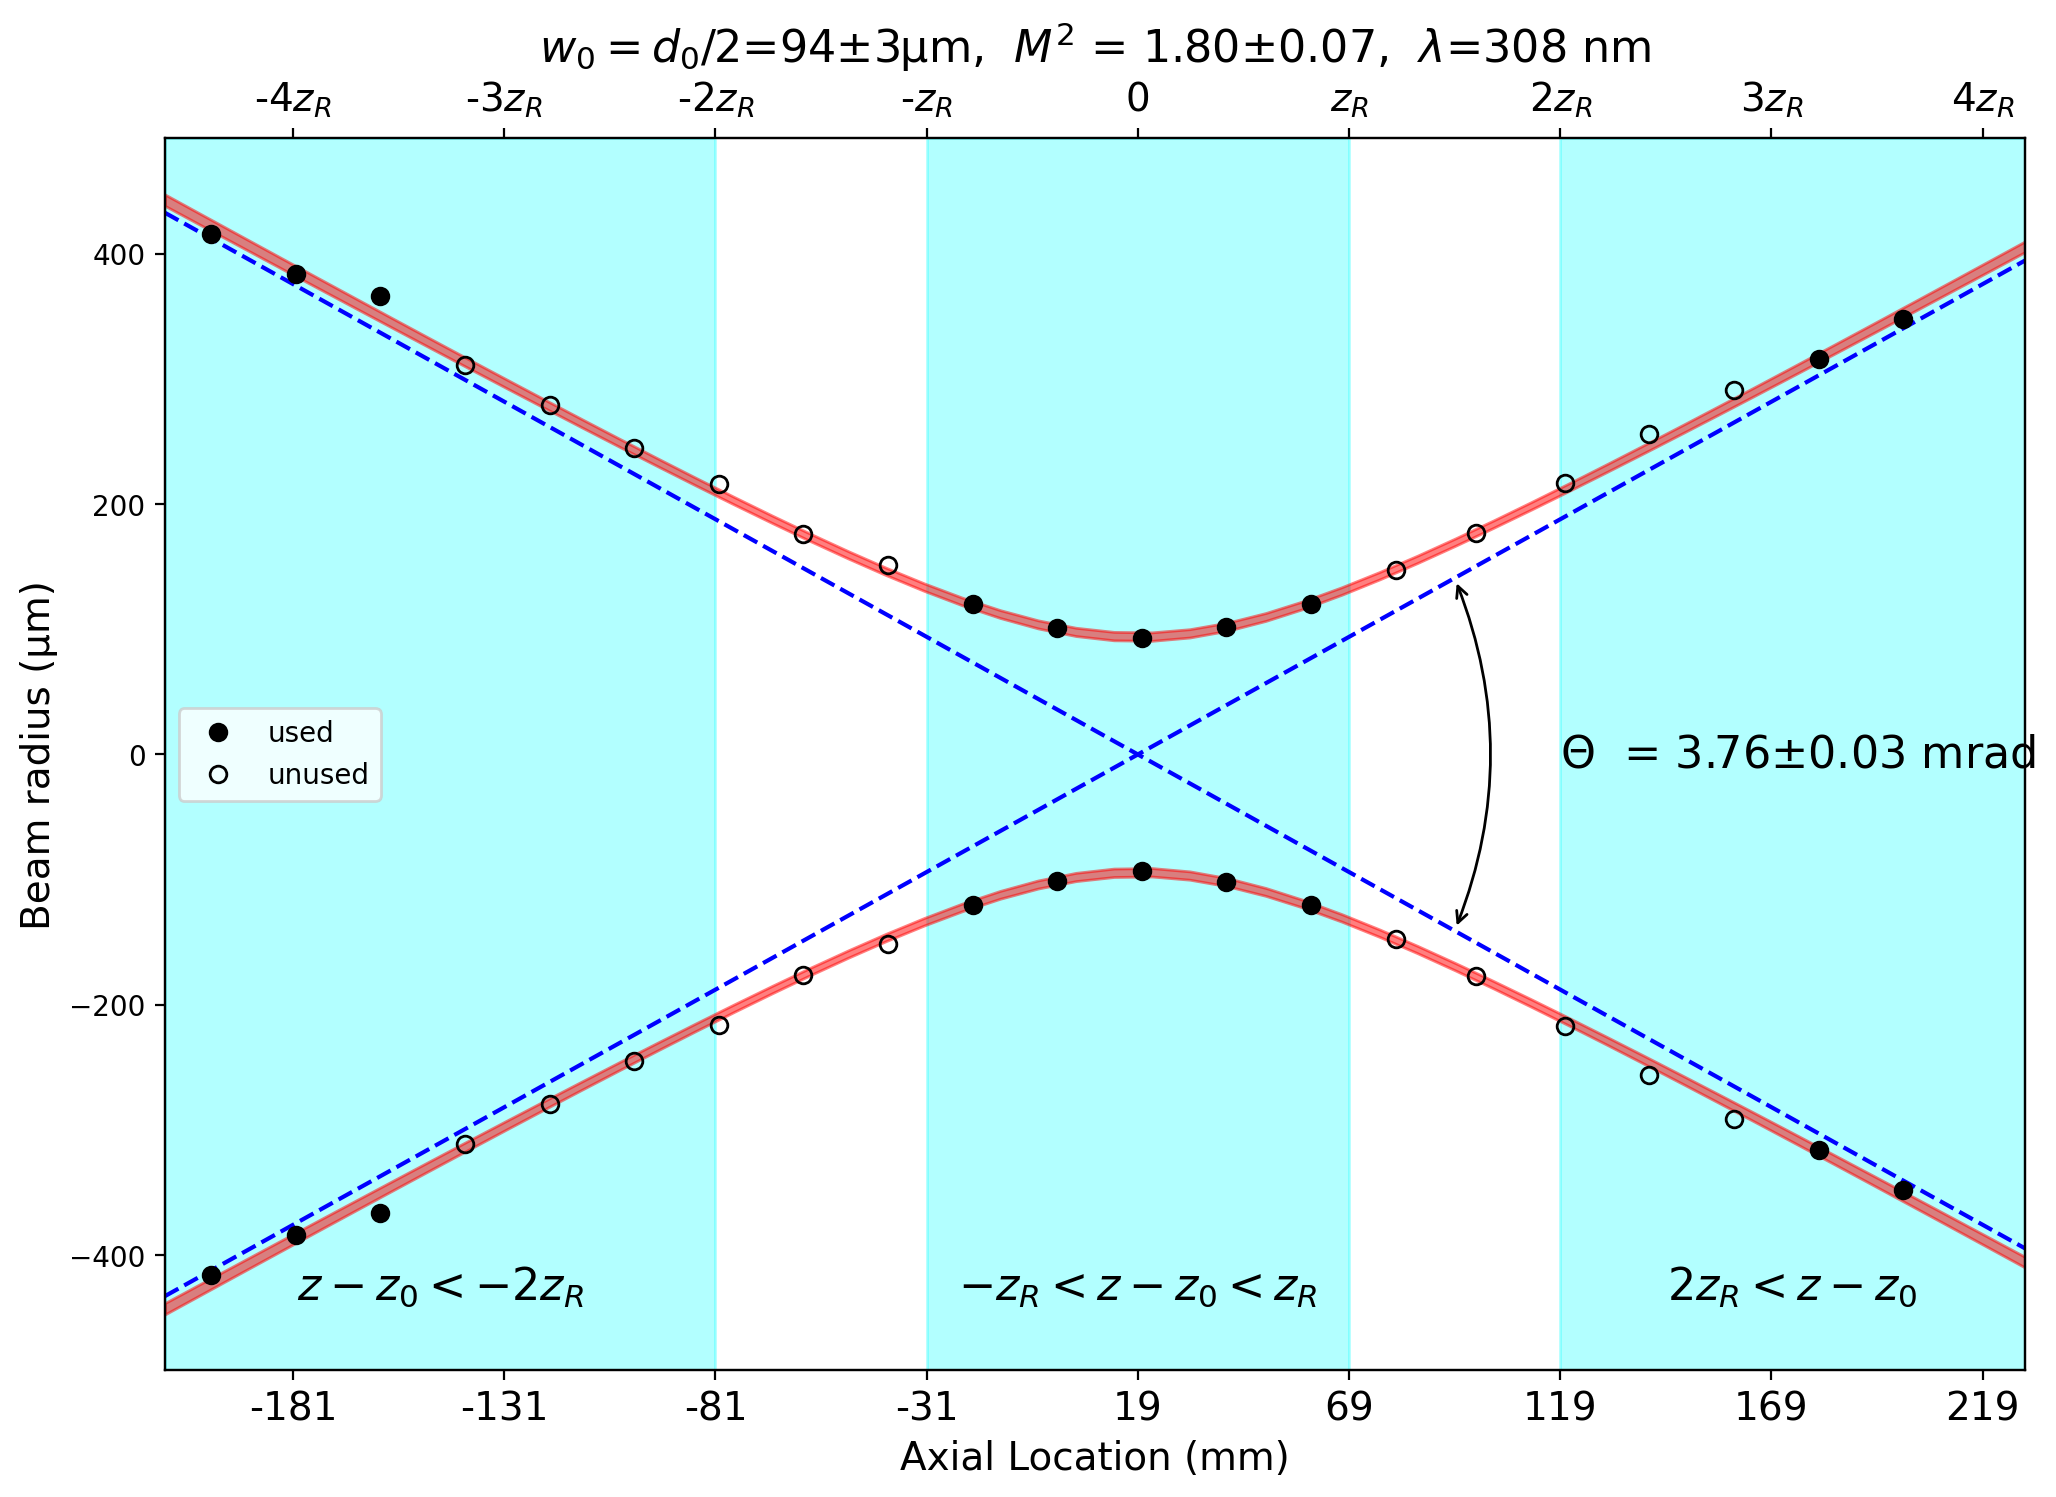

In [8]:
lambda1 = 308e-9  # meters
z1_all = (
    np.array(
        [
            -200,
            -180,
            -160,
            -140,
            -120,
            -100,
            -80,
            -60,
            -40,
            -20,
            0,
            20,
            40,
            60,
            80,
            99,
            120,
            140,
            160,
            180,
            200,
        ]
    )
    * 1e-3
)
d1_all = (
    2
    * np.array(
        [
            416,
            384,
            366,
            311,
            279,
            245,
            216,
            176,
            151,
            120,
            101,
            93,
            102,
            120,
            147,
            177,
            217,
            256,
            291,
            316,
            348,
        ]
    )
    * 1e-6
)
lbs.M2_radius_plot(z1_all, d1_all, lambda1, strict=True)
plt.savefig("m2fit.png", bbox_inches="tight")

plt.show()

### Montage of beam image analysis

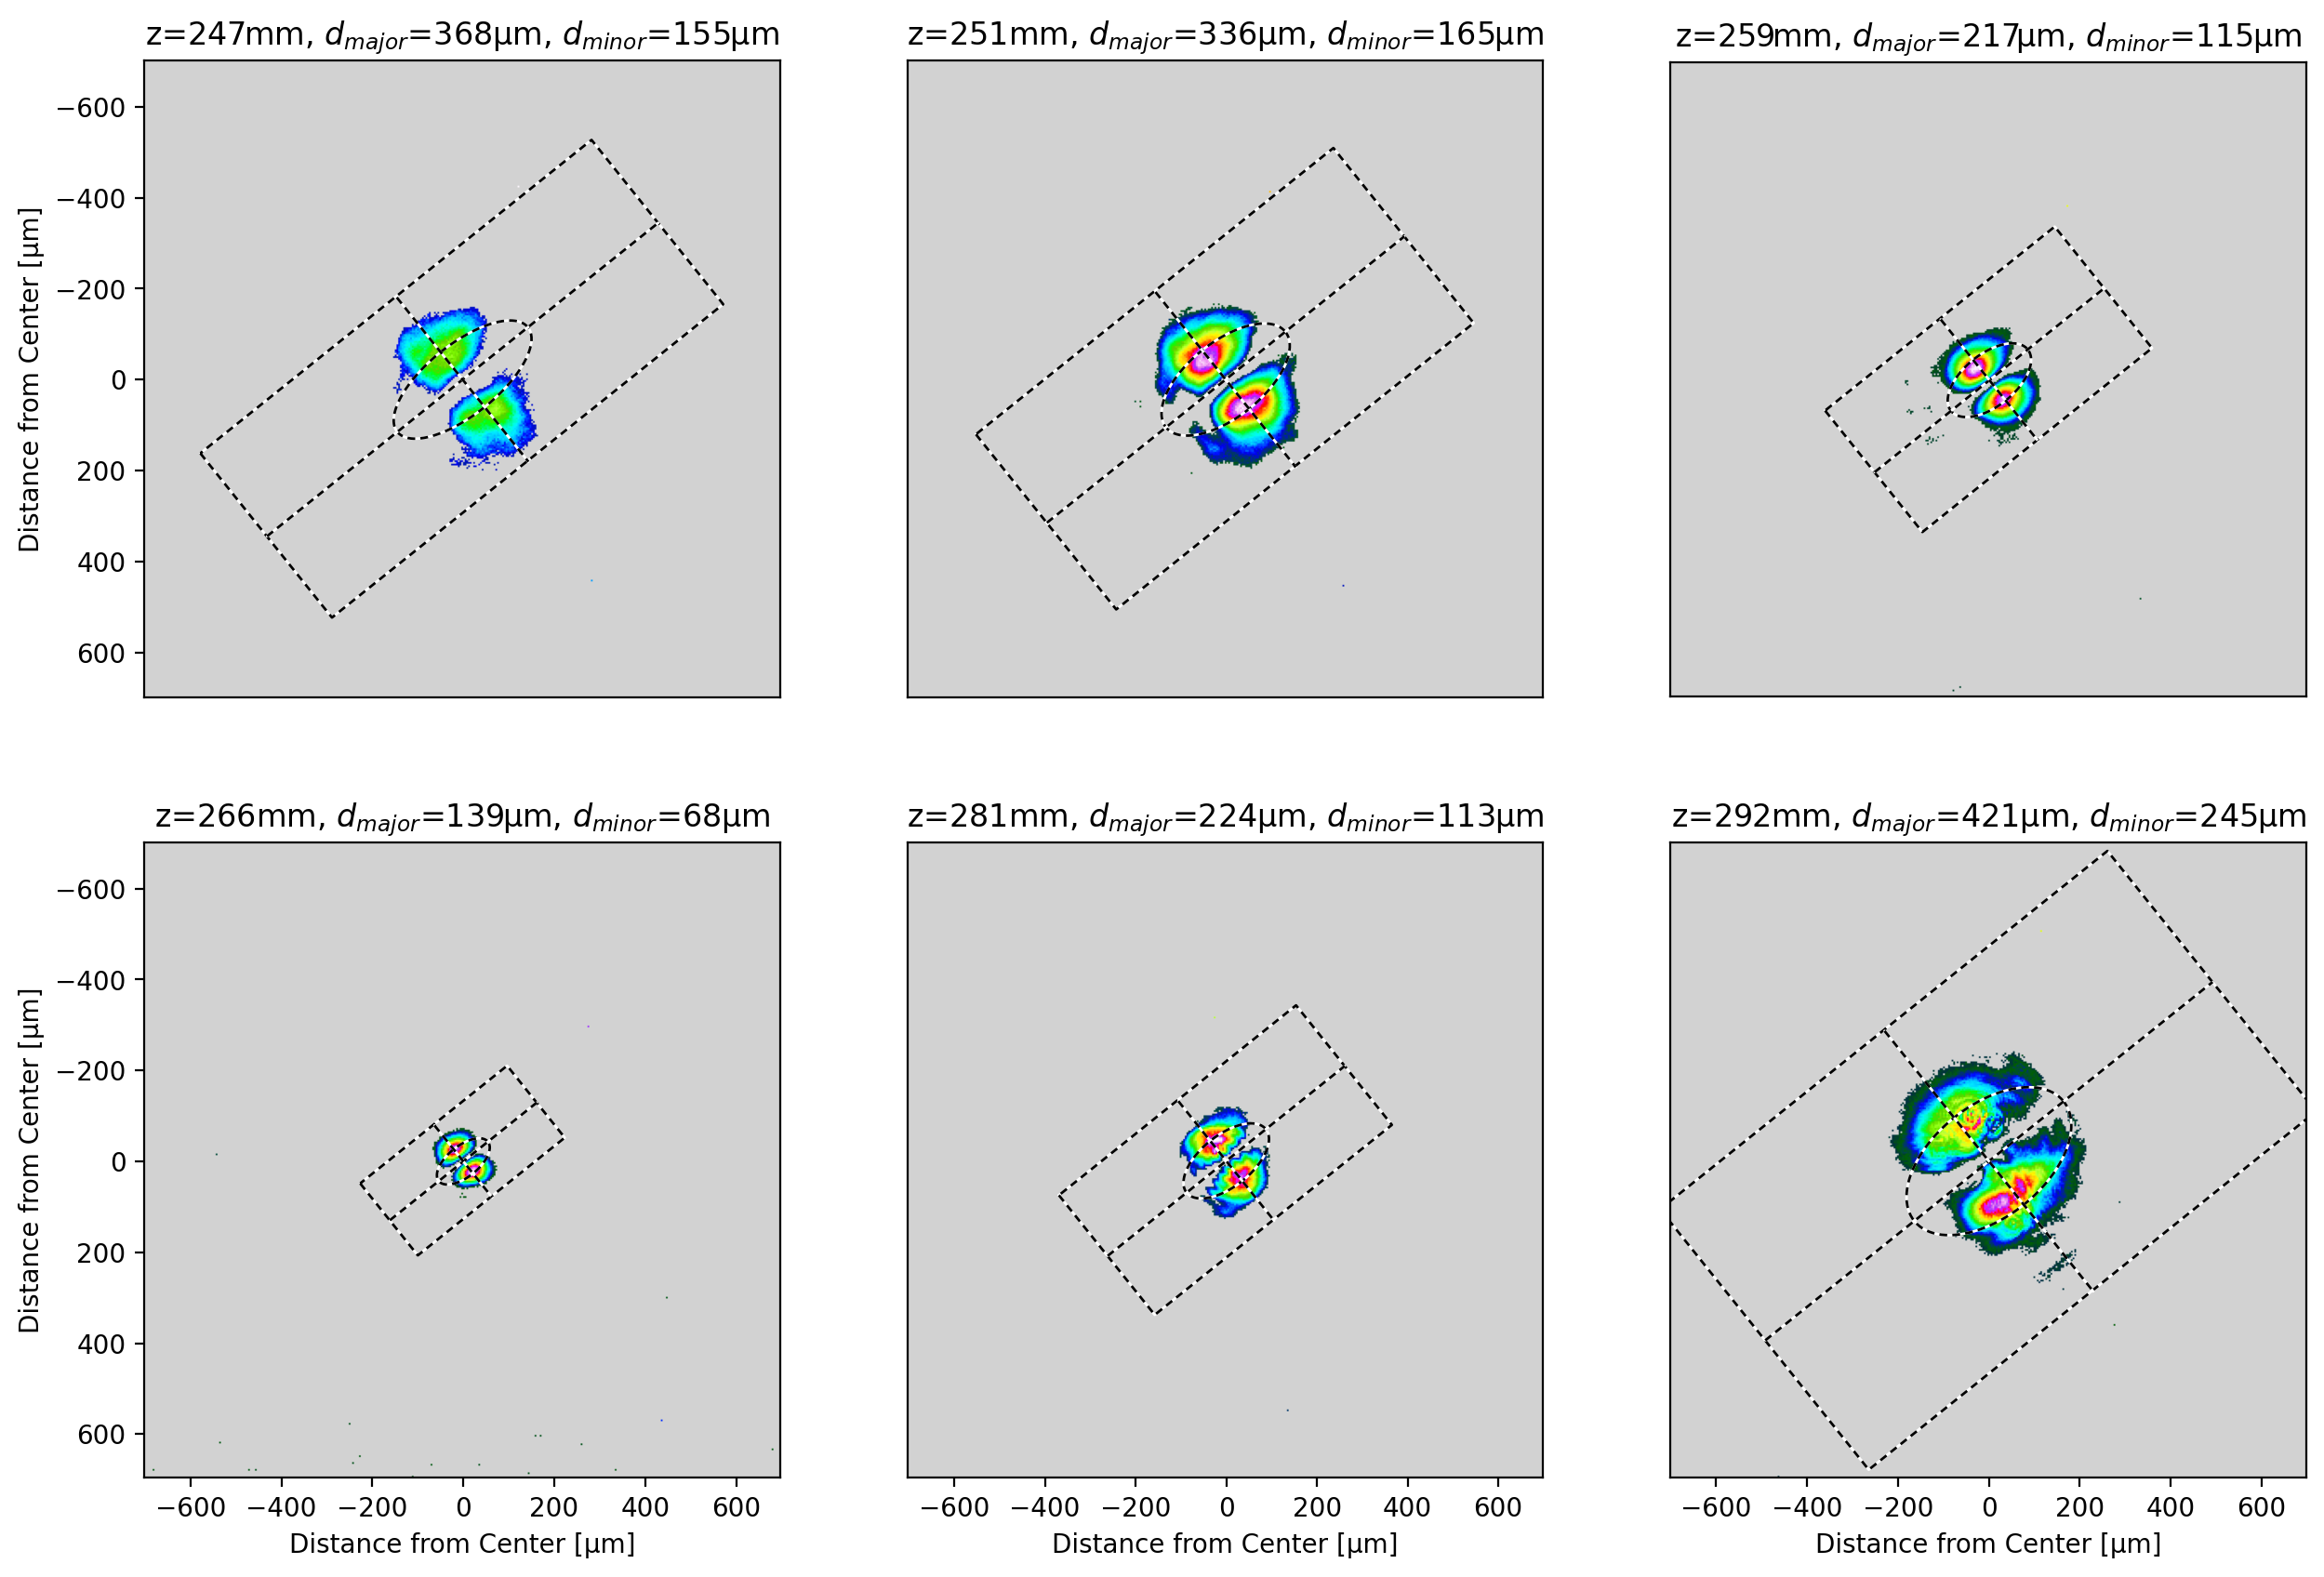

In [9]:
lambda0 = 632.8e-9  # meters
z10 = np.array([247, 251, 259, 266, 281, 292]) * 1e-3  # meters
filenames = [repo + "sb_%.0fmm_10.pgm" % (number * 1e3) for number in z10]

# the 12-bit pixel images are stored in high-order bits in 16-bit values
tem10 = [iio.imread(name) >> 4 for name in filenames]

# remove top to eliminate artifact
for i in range(len(z10)):
    tem10[i] = tem10[i][200:, :]

# find beam in all the images rotated 38.7° and create arrays of beam diameters
fixed_rotation = np.radians(38.7)
options = {
    "pixel_size": 3.75,
    "units": "µm",
    "crop": [1400, 1400],
    "z": z10,
    "phi_fixed": fixed_rotation,
}

d_minor, d_major = lbs.plot_image_montage(tem10, **options, iso_noise=False)  # d_minor and d_major in microns
plt.savefig("sbmontage.png", bbox_inches="tight")

plt.show()

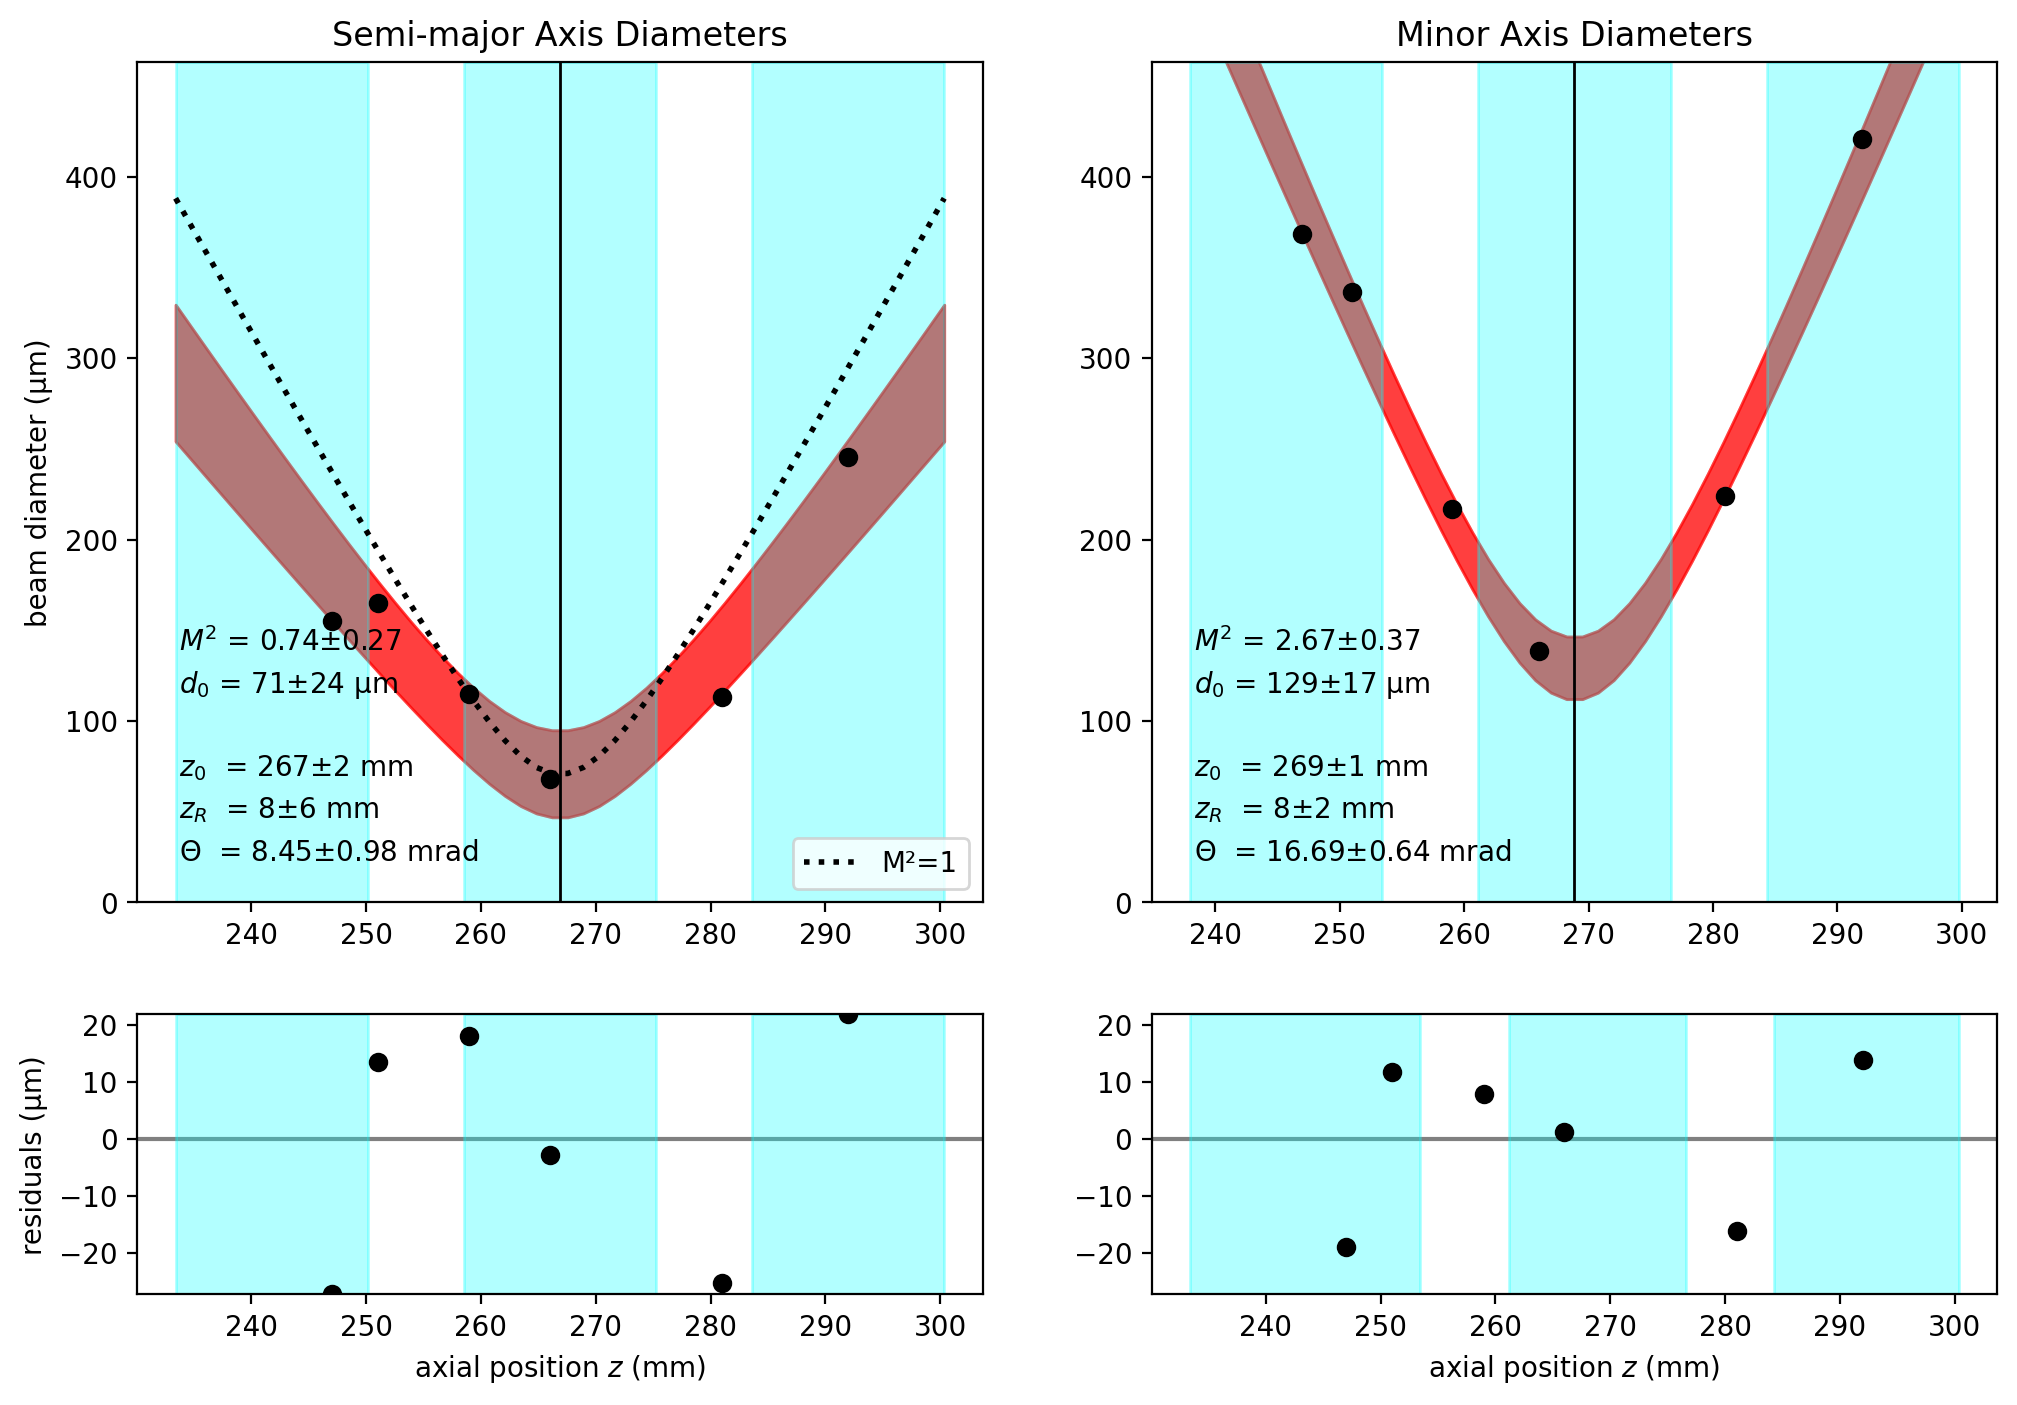

In [10]:
# fit and show
lbs.M2_diameter_plot(z10, d_major * 1e-6, lambda0, d_minor=d_minor * 1e-6)
plt.savefig("sbfit.png", bbox_inches="tight")